In [2]:
#notes i think the old images did not work as it was a grayscale image where each different gray color was a float like 0.26 which is not good for crossentropyloss since it requires integers

# USAGE
# python train.py
# import the necessary packages
#from pyimagesearch.dataset2 import SegmentationDataset
from pyimagesearch.model3 import UNet
from pyimagesearch import config
from torch.utils.data import DataLoader

#from torchvision import transforms
from torch.nn import CrossEntropyLoss #we will use crossEntropyLoss here since we have multiple classes
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.transforms import v2
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
from PIL import Image

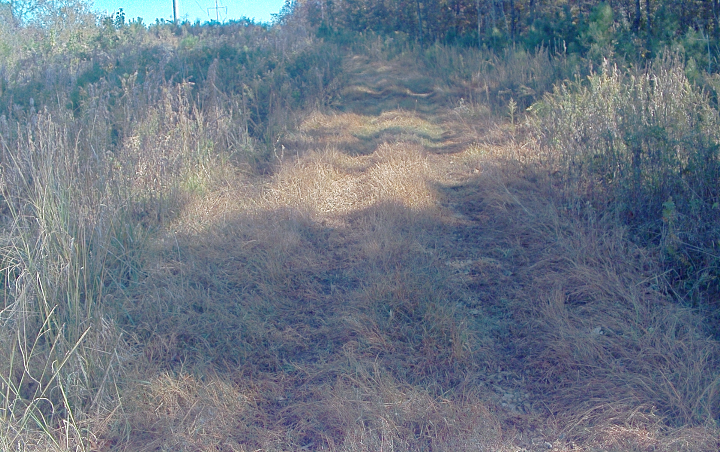

In [3]:
mask = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/masks/mask_101.png")
img = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/imgs/img_101.png")
anno = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/annos/anno_101.jpg")
annoIntMapMask = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/annos/int_maps/mask_101.png")

yeet = Image.open("/scratch/aniemcz/CAT/mixed/Train/annos/int_maps/anno_pln_414.png")
yeet2 = Image.open("/scratch/aniemcz/CAT/mixed/Train/imgs/img_pln_414.png")
yeet2
#We want the img as input and the annoIntMapMask as the target / labels

In [4]:
# import the necessary packages
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import os
from PIL import Image 
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, root, split, transforms=None):
        #loop through each location
        #Go into the split folder
        #Go into images and masks since they will be in pairs
        
        # store the image and mask filepaths, and augmentation
        # transforms
        self.root = root
        
        self.transforms = transforms
        
        #split is included b/c the data has a train, val, and test folder 
        #ex: urRootPath/Brown_Field/Train/annos/int_maps/mask_101.png  (mask in train folder)
        #ex: urRootPath/ (img in val folder)
        
        #stores the image paths and mask paths (duh)
        self.image_paths = []
        self.mask_paths = []
        
        #weird, int_map masks in brown_field is named mask_numberHere.png while in Powerline its anno_pln_numberHere.png
        for trail_name in os.listdir(self.root):
            split_path = os.path.join(root, trail_name, split.capitalize())
            imgs_path = os.path.join(split_path, "imgs")
            masks_path = os.path.join(split_path, "annos/int_maps/")
            for mask_name in os.listdir(masks_path):
                    
                    #Get the int_map mask first
                    mask_path = os.path.join(masks_path, mask_name)
                    self.mask_paths.append(mask_path)
            
                    #Get the corresponding image to that map_mask
                    image_name = "img_" + mask_name.split("_", 1)[1] #need to change file name a little for images
                    image_path = os.path.join(imgs_path, image_name)
                    self.image_paths.append(image_path)
        
        #The images are separated in different folders by trail so we need to loop through those
        #both images and masks have the same trail (b/c image must have a corresponding mask) so we only loop through that once
                    
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.image_paths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image, mask = self.transforms(image, mask)
        # return a tuple of the image and its mask
        return (image, mask)


In [5]:
from torchvision.transforms import InterpolationMode 

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        '''
        for t in self.transforms:
            torch.manual_seed(42) #the manual seed ensure that both the mask and target have the same parameters passed to the transformation done on the two 
            image = t(image)
            torch.manual_seed(42)
            target = t(target)
        '''
        #Numpy Array stores image data as [Height, Width, Num_Color_Channels]
        #Pytorch Tensor stores image data as [Num_Color_Channels, Height, Width]

        #We cannot use transforms.ToTensor() for masks as it normalizes the data between 0.0 and 1.0 which we dont want
        #So instead we first convert to numpy array and then to tensor of type int 64 to avoid this
        #Thus our integer labels in the image data is preserved
        
        flip = transforms.RandomHorizontalFlip(p=0.5)
        
        #mask
        #########################
        randResizeCrop = transforms.RandomResizedCrop(size=(config.INPUT_IMAGE_HEIGHT,config.INPUT_IMAGE_WIDTH), interpolation=InterpolationMode.NEAREST, antialias=False) # Or Resize(antialias=False)
        randRotate = transforms.RandomRotation(10, interpolation=InterpolationMode.NEAREST, fill=4) #the 4 will be specified to be ignored by cross-entropy loss (num has to be from 0-255 to work)
        
        torch.manual_seed(42)
        target = flip(target) #flip
        
        torch.manual_seed(42)
        target = randResizeCrop(target) #rand resize crop
        
        torch.manual_seed(42)
        target = randRotate(target) #rotate
        
        #however we do want to use ToTensor for images to normalize to help prevent giving too high of an initial value to color values
        
        target = np.array(target)
        target = torch.tensor(target, dtype=torch.int64) #int64 b/c target (in this case masks) have to be int64 for crossEntropyLoss
        
        #image
        #########################
        #Note, bicubic takes in like 4x the amount of pixels when doing the resize than bilinear so if its so slow maybe make that swap
        randResizeCrop = transforms.RandomResizedCrop(size=(config.INPUT_IMAGE_HEIGHT,config.INPUT_IMAGE_WIDTH), interpolation=InterpolationMode.BILINEAR)  # Or Resize(antialias=True)
        randRotate = transforms.RandomRotation(10, interpolation=InterpolationMode.BILINEAR)

        torch.manual_seed(42) 
        image = flip(image) #flip
        
        torch.manual_seed(42)
        image = randResizeCrop(image) #rand resize crop
        
        torch.manual_seed(42)
        image = randRotate(image) #rotate

        colorJitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        image = colorJitter(image)
        
        toTensor = transforms.ToTensor()
        image = toTensor(image)
        
        return image, target

#WARNING: Do not use Transform.ToTensor as it normalizes the data [0.0-1.0] which we don't want
#Aug apply to mask and img

#NOTES: 
#May try the timm randaug 
#
transform = [
    #v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image (supposedly this makes its faster but havent tried it)
    #WARNING: antialias=false is needed to prevent the pixels in mask from being blurred when stretched thus messing up the labelIds
    #transforms.RandomHorizontalFlip(p=0.5),
]

#WARNING: Interpolation nearrest is needed to prevent the pixels in mask from being blurred when stretched thus messing up the labelIds
#transform.append( transforms.Resize((config.INPUT_IMAGE_HEIGHT,config.INPUT_IMAGE_WIDTH), interpolation=Image.NEAREST )) 

transform = Compose(transform)

trainDS = SegmentationDataset('/scratch/aniemcz/CAT', split='Train',
	transforms=transform)
testDS = SegmentationDataset('/scratch/aniemcz/CAT', split='Test',
	transforms=transform)


In [6]:
#transforms.RandomResizedCrop??
#transforms.RandomRotation??

2536


/home/aniemcz/.conda/envs/universal/lib/python3.12/site-packages/torchvision/transforms/functional.py:465: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


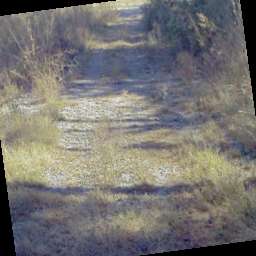

In [7]:

from torchvision.transforms.functional import to_pil_image
#Returns image and its mask
#print(len(os.listdir(trainDS.images_dir)))
#print(np.unique(trainDS[198][1]))
print(len(trainDS))
#only four classes?
#print(trainDS[198][1].unique()) #img shape: torch.Size([3, 128, 128])
#mask shape: torch.Size([1, 128, 128])
#Image.fromarray( np.array(trainDS[2261][1]) * 84 )
#trainDS[2260][0]
import random

i = random.randint(0, 2535)
#trainDS[i][0]
to_pil_image(trainDS[i][0])
#Image.fromarray( np.array(trainDS[i][1]) * 60 ) #The 4 is our "void" class we created to deal with how rotation changes the image

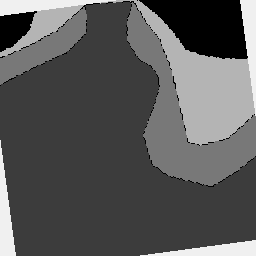

In [8]:
t = trainDS[i][1].to(torch.uint8) * 60
to_pil_image(t)

In [9]:
np.unique(np.array(trainDS[i][1]))

array([0, 1, 2, 3, 4])

In [10]:
print(np.array(trainDS[i][1])[0][0])

4


In [11]:
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)


[INFO] found 2536 examples in the training set...
[INFO] found 1088 examples in the test set...


In [11]:
trainDS[198][1].shape

torch.Size([256, 256])

In [12]:
trainDS[198][1].unique()
trainDS[198][1][127][1:100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [13]:
#We need to upsample / resize the output mask from the model to match the size of the original mask for that image
# so transform.resize() nearest interpolation
#

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode 

def calc_miou(model, val_loader, num_classes=4):
        # Instantiate the model
        model.eval()

        predictions = []
        targets = []

        with torch.no_grad():
            #for a,b,c in val_loader:
             #   print(c)
            for idx, batch in enumerate(tqdm(val_loader)):
                #should be batch sizes of 1
                
                #get original mask as image and then convert to numpy array
                origMask = Image.open(val_loader.dataset.mask_paths[idx])
                origMaskWidth, origMaskHeight = origMask.size #returns tuple in format (width, height) 
                origMaskNpArr = np.array(origMask)
                
                #We want the original image without the data aug applied to it and as a tensor stored on the gpu since the model is on the gpu
                origImg = Image.open(val_loader.dataset.image_paths[idx])
                toTensor = transforms.ToTensor()
                origImgTensor = toTensor(origImg).to(config.DEVICE)

                #add a batch dimension of size 1 to the origImgTensor so that it works with the model
                origImgTensor = origImgTensor.unsqueeze(0)
                
                #print(f'input tensor shape is {origImgTensor.shape}')
                
                outputs = model(origImgTensor)
                #print(f'outputs shape is {outputs.shape}')

                #same thing as doing argmax since the second item returned of max is basically argmax src: https://pytorch.org/docs/stable/generated/torch.argmax.html
                #_, predicted = torch.max(outputs, dim=1)
                predicted = torch.argmax(outputs, dim=1)
                
                #now witht the predicted mask tensor we need to resize it to match the size of the original mask
                #turn off anti-aliasing since we need to preserve the int labels
                resize = transforms.Resize((origMaskHeight, origMaskWidth), interpolation=InterpolationMode.NEAREST, antialias=False) #pytorch expects size to be passed as (h, w)
                predicted = resize(predicted) #resize the predicted mask tensor
                
                #print(predicted.unique())
                #assert False
                
                predictions.append(predicted.cpu().numpy())
                #targets.append(labels.numpy())
                targets.append(origMaskNpArr) # we do this since we want to compare our prediction to the original mask and not to the augmented training one
                
        predictions = np.concatenate(predictions, axis=0)
        targets = np.concatenate(targets, axis=0).astype(np.int64)

        # Ensure targets and predictions are 1D arrays
        targets = targets.flatten()
        predictions = predictions.flatten()

        print("Unique values in targets:", np.unique(targets))
        print("Unique values in predictions:", np.unique(predictions))

        confusion_mat = confusion_matrix(targets, predictions)

        # Calculate IoU for each class
        iou_per_class = np.diag(confusion_mat) / (confusion_mat.sum(axis=1) + confusion_mat.sum(axis=0) - np.diag(confusion_mat))

        # Calculate mean IoU
        mean_iou = np.nanmean(iou_per_class)

        print("iou_per_class")

        i=0
        while i < num_classes:
            print("iou for class {}: {}".format(i, iou_per_class[i]) )
            i+=1

        print(iou_per_class)

        print(f"Mean IoU: {mean_iou}")
        
        # Display the confusion matrix
        #disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[str(i) for i in range(4)])
        #disp.plot(cmap='viridis')

        #plt.title('Confusion Matrix')
        #plt.show()
        
        return mean_iou

In [15]:
testLoaderEval = DataLoader(testDS, shuffle=False,
	batch_size=1, pin_memory=config.PIN_MEMORY)

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# initialize our UNet model
unet = UNet(in_channels=3, classes=4).to(config.DEVICE)
# initialize loss function and optimizer
#0 is the index for everything that isn't the traversable terrain
#REMOVED IGNORE_INDEX=0 SINCE DIDNT KNOW HOW TO FIX THIS WITH MIOU FOR NOW
#Should try to see if I instead just do ignore_index = 0 to ignore the forest and background entirely
lossFunc = CrossEntropyLoss(ignore_index=4)
#added weight decay and
opt = Adam(unet.parameters(), lr=config.INIT_LR, weight_decay=config.WEIGHT_DECAY)
#scheduler uses miou to measure (higher miou is better so we use max)
scheduler = ReduceLROnPlateau(opt, mode='max', factor=config.SCHED_FACTOR, patience=config.SCHED_PATIENCE)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "accuracies": []}


In [17]:
#unet

In [18]:
from torch.nn import Softmax
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(config.NUM_EPOCHS):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	trainLoader = tqdm(trainLoader)
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	
	# switch off of autograd occurs in the calc_miou function and also the e % 5 is so it only takes miou every 5 epochs
	if (e+1) % 5 == 0 and (e+1) != 0: #calc miou on every 5th epoch
	#if True==True: #will calculate miou on every epoch
		#Scheduler to reduce learning rate once the miou isnt improving that much
		miou = calc_miou(unet, testLoaderEval)
		scheduler.step(miou)
		#record miou and the epoch
		H["accuracies"].append({"miou":miou, "epoch": e}) #adds dict containing miou and the epoch
	avgTrainLoss = totalTrainLoss / trainSteps
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}".format(
		avgTrainLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 0/2536 [00:00<?, ?it/s]/home/aniemcz/.conda/envs/universal/lib/python3.12/site-packages/torchvision/transforms/functional.py:465: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
100%|██████████| 2536/2536 [01:32<00:00, 27.50it/s]


[INFO] EPOCH: 1/1
Train loss: 0.750513
[INFO] total time taken to train the model: 92.25s


In [19]:
'''
#training loss down to 0.481507
# plot the training loss
plt.style.use("ggplot")
plt.figure()
#plt.plot(H["train_loss"], label="train_loss")
#plt.plot(H["test_loss"], label="test_loss")
mious = [miou["miou"] for miou in H["accuracies"]]
epochs = [epoch["epoch"] for epoch in H["accuracies"]]
plt.plot(mious, label="MIoU")
#plt.plot(epochs, label="Epoch")
plt.title("UNET")
plt.xlabel("Epoch")
plt.ylabel("MIoU")
plt.legend(loc="upper left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)
'''

'\n#training loss down to 0.481507\n# plot the training loss\nplt.style.use("ggplot")\nplt.figure()\n#plt.plot(H["train_loss"], label="train_loss")\n#plt.plot(H["test_loss"], label="test_loss")\nmious = [miou["miou"] for miou in H["accuracies"]]\nepochs = [epoch["epoch"] for epoch in H["accuracies"]]\nplt.plot(mious, label="MIoU")\n#plt.plot(epochs, label="Epoch")\nplt.title("UNET")\nplt.xlabel("Epoch")\nplt.ylabel("MIoU")\nplt.legend(loc="upper left")\nplt.savefig(config.PLOT_PATH)\n# serialize the model to disk\n#torch.save(unet, config.MODEL_PATH)\n'

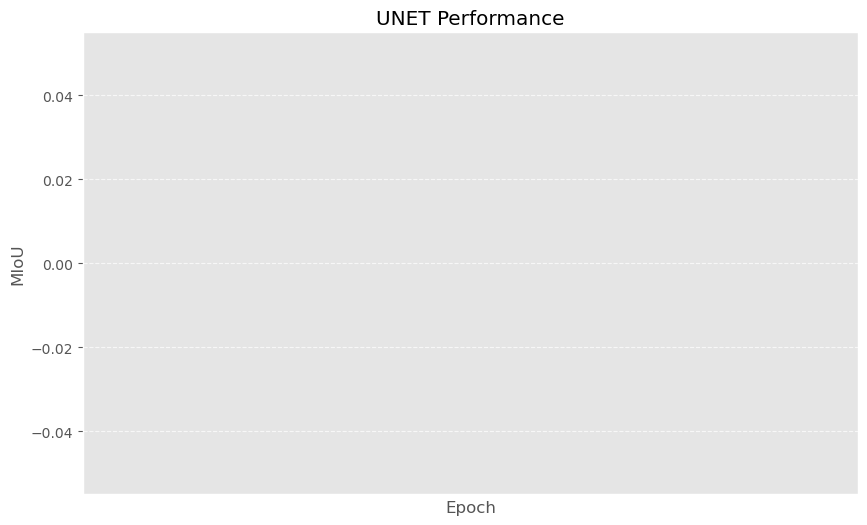

In [20]:
import matplotlib.pyplot as plt

# Extract MIoU and epoch data
mious = [miou["miou"] for miou in H["accuracies"]]
epochs = [epoch["epoch"] for epoch in H["accuracies"]]

# Create the plot
plt.style.use("ggplot")
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot MIoU against epochs
plt.plot(epochs, mious, label="MIoU", marker='o')

# Set labels and title
plt.title("UNET Performance")
plt.xlabel("Epoch")
plt.ylabel("MIoU")

# Add legend
#plt.legend(loc="best")

# Customize x-axis ticks
plt.xticks(epochs)  # Show every 5th epoch on x-axis, adjust as needed

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure
plt.savefig(config.PLOT_PATH)
#plt.close()

# Optionally, display the plot
plt.show()

# Serialize the model to disk
#torch.save(unet.state_dict(), config.MODEL_PATH)
torch.save(unet, config.MODEL_PATH)

In [21]:
import json
with open("output/data.json", "w") as json_file:
    json.dump(H, json_file, indent=4)

In [22]:
epochs

[]

[INFO] loading up test image paths...
[INFO] load up model...


  0%|          | 0/1088 [00:00<?, ?it/s]/home/aniemcz/.conda/envs/universal/lib/python3.12/site-packages/torchvision/transforms/functional.py:465: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


Input shape y is torch.Size([1, 224, 224])
y unique tensor([0, 1, 2, 3], device='cuda:0')
origMask has these unique integers [0 1 2 3]
Input shape X is torch.Size([1, 3, 224, 224])


  0%|          | 0/1088 [00:00<?, ?it/s]

unique int for pred mask is tensor([-24.3649, -24.1545, -24.0045,  ...,  29.1121,  29.2072,  29.2427],
       device='cuda:0')
Output shape is torch.Size([1, 4, 224, 224])
Pred_labels shape is torch.Size([1, 224, 224])
Number of unique label ids is 4


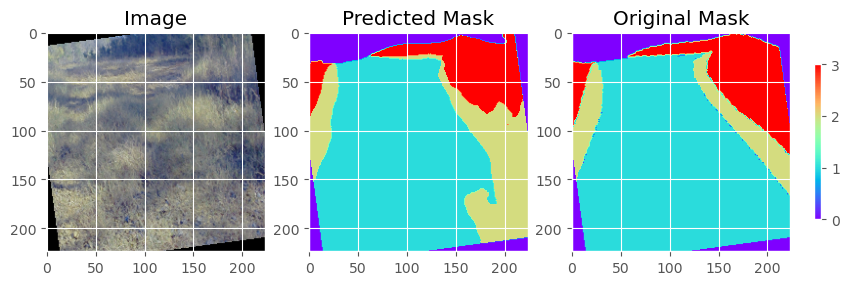

In [19]:
#MANY IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask, numClasses=4):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	norm = mcolors.Normalize(vmin=0, vmax=numClasses-1) #needed so original and predicted mask have same color for each integer index
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask, cmap="rainbow", norm=norm)
	origMaskImg = ax[2].imshow(origMask, cmap="rainbow", norm=norm)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	# Add colorbar
	cbar = figure.colorbar(origMaskImg, ax=ax, orientation='vertical', fraction=0.01, pad=0.03)
	cbar.set_ticks(range(numClasses))
	cbar.set_ticklabels([str(i) for i in range(numClasses)])
	#figure.tight_layout()
	figure.show()
#JFEOSJFOEJFOSEJFOEJFOJFOSEJFOJESOFJESOFJ
#Need to fix this ?!??!?@?D??@FFDFEF?EF?E?F?ES?F?EF??EF?E?SF?SE!!!!J!!OJ!OJ!O!JO!JO!
def make_predictions(model, dataLoader):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
		for idx, batch in enumerate(tqdm(dataLoader)):
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				X, y = batch # here 's' is the name of the file stored in the root directory
				X, y = X.to(config.DEVICE), y.to(config.DEVICE)
				print("Input shape y is {}".format(y.shape))
				print("y unique {}".format(y.unique()))
				toPilImage = transforms.ToPILImage()
				image = toPilImage(X.squeeze().to('cpu'))
				origMask = y.squeeze().to('cpu')
				print("origMask has these unique integers {}".format(np.unique( np.array(origMask) ) ) )
				print("Input shape X is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				print("unique int for pred mask is {}".format(predictions.unique()))
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				#pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				#print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				break #so it only iterates once          
	prepare_plot(image, pred_labels.squeeze(), origMask)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
trainLoaderEval = DataLoader(testDS, shuffle=True,
	batch_size=1, pin_memory=config.PIN_MEMORY,
	)
make_predictions(unet, trainLoaderEval)


[INFO] loading up test image paths...
[INFO] load up model...
Input shape is torch.Size([1, 3, 256, 256])
Output shape is torch.Size([1, 4, 256, 256])
Pred_labels shape is torch.Size([1, 256, 256])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

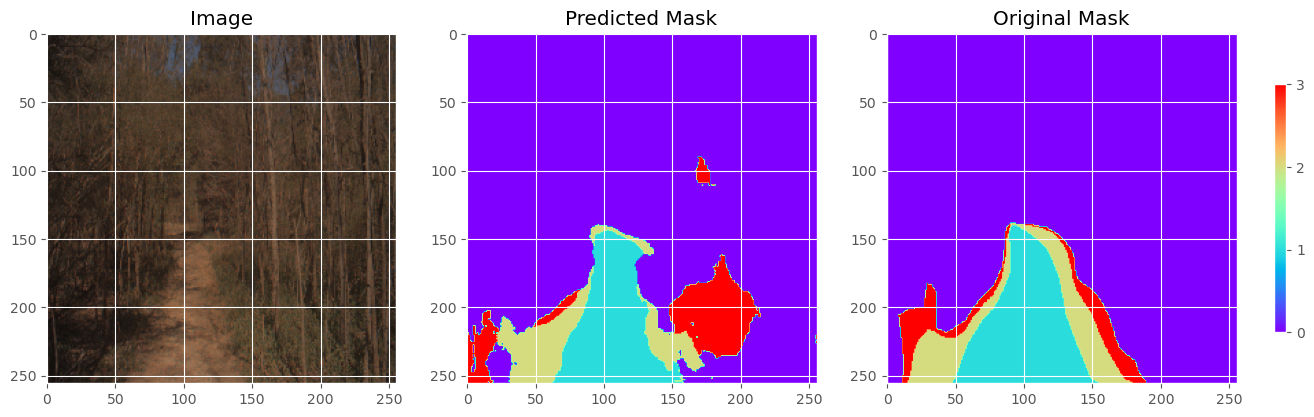

In [20]:
#SINGLE IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask, numClasses=4):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
	# plot the original image, its mask, and the predicted mask
	norm = mcolors.Normalize(vmin=0, vmax=numClasses-1) #needed so original and predicted mask have same color for each integer index
	
	ax[0].imshow(origImage)
	predMaskImg = ax[1].imshow(predMask, cmap="rainbow", norm=norm) 
	origMaskImg = ax[2].imshow(origMask, cmap="rainbow", norm=norm) #store as variable also to be used for colorbar
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	# Add colorbar
	cbar = figure.colorbar(origMaskImg, ax=ax, orientation='vertical', fraction=0.01, pad=0.03)
	cbar.set_ticks(range(numClasses))
	cbar.set_ticklabels([str(i) for i in range(numClasses)])
	#figure.tight_layout()
	figure.show()
def make_predictions(model, imagePath, maskPath):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				image = Image.open(imagePath)
				maskImg = Image.open(maskPath)
				# resize the image and make a copy of it for visualization
				image = image.resize((256,256), resample=Image.NEAREST)
				maskImg = maskImg.resize((256,256), resample=Image.NEAREST)
				PILtoTensor = transforms.ToTensor()
				X = PILtoTensor(image)
				X = X.to(config.DEVICE) #converts to tensor and moves to gpu if there is gpu
				X = X.unsqueeze(0) #this is the model normally expacts input in the form of torch.Size([batch_size, num_channels, height, width])
				#but X right now is in the form of [3, 128, 128] so we do unsqueeze to convert it to [1, 3, 128, 128] for predicting on our one image
				print("Input shape is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				#pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				#pred_labels = pred_labels.squeeze()                
	# Functions to save predictions as images 
	def save_as_images(tensor_pred, image_name):
		tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
		#filename = f"{folder}\{image_name}.png"
		filename = f"{image_name}.png"
		tensor_pred.save(filename)
	save_as_images(pred_labels, "yeet")
	prepare_plot(image, pred_labels.squeeze(), maskImg)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
#imgPath = "dataset/data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
#maskPath = "dataset/data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"
imgPath = "/scratch/aniemcz/CAT/Brown_Field/Train/imgs/img_101.png"
maskPath = "/scratch/aniemcz/CAT/Brown_Field/Train/annos/int_maps/mask_101.png"

imgPath = "/scratch/aniemcz/CAT/Brown_Field/Test/imgs/img_118.png"
maskPath = "/scratch/aniemcz/CAT/Brown_Field/Test/annos/int_maps/mask_118.png"

imgPath = "/scratch/aniemcz/CAT/Main_Trail/Test/imgs/img_251.png"
maskPath = "/scratch/aniemcz/CAT/Main_Trail/Test/annos/int_maps/mask_251.png"

make_predictions(unet, imgPath, maskPath)


In [21]:
def eval_IoU(model, val_loader):
    
    model.eval()
    interaction = AverageMeter()
    union = AverageMeter()
    
    iou = SegIoU(num_classes=4, ignore_index=None)
    
    with torch.inference_mode():
        for feed_dict in val_loader:
            images, mask = feed_dict["data"].cuda(), feed_dict["label"].cuda()
            
            output = model(images)
            

In [16]:
import numpy as np

def calc_miou2(model, test_loader, num_classes=4):
    def calculate_iou(pred, target):
        iou_per_class = []
        #pred = torch.argmax(pred, dim=1)

        for cls in range(num_classes):
            pred_inds = (pred == cls)
            target_inds = (target == cls)

            intersection = (pred_inds & target_inds).sum().item()
            union = (pred_inds | target_inds).sum().item()

            if union == 0:
                iou_per_class.append(float('nan'))
            else:
                iou_per_class.append(intersection / union)

        return iou_per_class
    
    def mean_iou(iou_list):
        valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
        return np.mean(valid_iou)
    
    iou_scores = []
    
    predictions = []
    targets = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_loader)):
                #should be batch sizes of 1
                inputs, labels = batch 
                inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
                outputs = model(inputs)

                #same thing as doing argmax since the second item returned of max is basically argmax src: https://pytorch.org/docs/stable/generated/torch.argmax.html
                #_, predicted = torch.max(outputs, dim=1)
                predicted = torch.argmax(outputs, dim=1) 
                
                predicted = predicted.to('cpu')
                labels = labels.to('cpu')

                predictions.append(predicted.cpu())
                targets.append(labels)
                
                if idx == 100:
                    break
                
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0).astype(np.int64)

    # Ensure targets and predictions are 1D arrays
    targets = targets.flatten()
    predictions = predictions.flatten()
    
    iou = calculate_iou(predictions, targets)
    iou_scores.append(iou)
    
    #Compute mean IoU
    iou_scores = np.array(iou_scores)
    miou_per_class = np.nanmean(iou_scores, axis=0)
    miou = mean_iou(miou_per_class)
    return miou

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode 

def calc_miou(model, val_loader, num_classes=4):
        # Instantiate the model
        model.eval()

        predictions = []
        targets = []

        with torch.no_grad():
            #for a,b,c in val_loader:
             #   print(c)
            for idx, batch in enumerate(tqdm(val_loader)):
                #should be batch sizes of 1
                if idx < 500 or idx > 900:
                    continue
                
                #get original mask as image and then convert to numpy array
                origMask = Image.open(val_loader.dataset.mask_paths[idx])
                origMaskWidth, origMaskHeight = origMask.size #returns tuple in format (width, height) 
                origMaskNpArr = np.array(origMask)
                
                #We want the original image without the data aug applied to it and as a tensor stored on the gpu since the model is on the gpu
                origImg = Image.open(val_loader.dataset.image_paths[idx])
                toTensor = transforms.ToTensor()
                origImgTensor = toTensor(origImg).to(config.DEVICE)

                #add a batch dimension of size 1 to the origImgTensor so that it works with the model
                origImgTensor = origImgTensor.unsqueeze(0)
                
                #print(f'input tensor shape is {origImgTensor.shape}')
                
                outputs = model(origImgTensor)
                #print(f'outputs shape is {outputs.shape}')

                #same thing as doing argmax since the second item returned of max is basically argmax src: https://pytorch.org/docs/stable/generated/torch.argmax.html
                #_, predicted = torch.max(outputs, dim=1)
                predicted = torch.argmax(outputs, dim=1)
                
                #now witht the predicted mask tensor we need to resize it to match the size of the original mask
                #turn off anti-aliasing since we need to preserve the int labels
                resize = transforms.Resize((origMaskHeight, origMaskWidth), interpolation=InterpolationMode.NEAREST, antialias=False) #pytorch expects size to be passed as (h, w)
                predicted = resize(predicted) #resize the predicted mask tensor
                
                #print(predicted.unique())
                #assert False
                
                predictions.append(predicted.cpu().numpy())
                #targets.append(labels.numpy())
                targets.append(origMaskNpArr) # we do this since we want to compare our prediction to the original mask and not to the augmented training one
                
                #if idx == 1000:
                    #break
                
        #return predictions
        
        print("here")
        
        #predictions = np.append(predictions)
        #targets = np.append(targets)
        
        predictions = np.concatenate(predictions, axis=None)
        targets = np.concatenate(targets, axis=None).astype(np.int64)
        

        # Ensure targets and predictions are 1D arrays
        #targets = targets.flatten()
        #predictions = predictions.flatten()

        #print("Unique values in targets:", np.unique(targets))
        #print("Unique values in predictions:", np.unique(predictions))

        confusion_mat = confusion_matrix(targets, predictions)

        # Calculate IoU for each class
        iou_per_class = np.diag(confusion_mat) / (confusion_mat.sum(axis=1) + confusion_mat.sum(axis=0) - np.diag(confusion_mat))

        # Calculate mean IoU
        mean_iou = np.nanmean(iou_per_class)

        print("iou_per_class")

        i=0
        while i < num_classes:
            print("iou for class {}: {}".format(i, iou_per_class[i]) )
            i+=1

        print(iou_per_class)

        print(f"Mean IoU: {mean_iou}")
        
        # Display the confusion matrix
        #disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[str(i) for i in range(4)])
        #disp.plot(cmap='viridis')

        #plt.title('Confusion Matrix')
        #plt.show()
        
        return mean_iou

In [13]:
def test(model, val_loader, num_classes=4):
    from torchmetrics.classification import MulticlassJaccardIndex

    jaccard = MulticlassJaccardIndex(num_classes=num_classes).to(config.DEVICE)

    #for idx in range(num_items):
    for idx, batch in enumerate(tqdm(val_loader)):
        # ... (existing code for processing each batch)
                #get original mask as image and then convert to numpy array
        origMask = Image.open(val_loader.dataset.mask_paths[idx])
        origMaskWidth, origMaskHeight = origMask.size #returns tuple in format (width, height) 
        origMaskNpArr = np.array(origMask)

        #We want the original image without the data aug applied to it and as a tensor stored on the gpu since the model is on the gpu
        origImg = Image.open(val_loader.dataset.image_paths[idx])
        toTensor = transforms.ToTensor()
        origImgTensor = toTensor(origImg).to(config.DEVICE)

        #add a batch dimension of size 1 to the origImgTensor so that it works with the model
        origImgTensor = origImgTensor.unsqueeze(0)

        #print(f'input tensor shape is {origImgTensor.shape}')

        outputs = model(origImgTensor)
        #print(f'outputs shape is {outputs.shape}')

        #same thing as doing argmax since the second item returned of max is basically argmax src: https://pytorch.org/docs/stable/generated/torch.argmax.html
        #_, predicted = torch.max(outputs, dim=1)
        predicted = torch.argmax(outputs, dim=1)

        #now witht the predicted mask tensor we need to resize it to match the size of the original mask
        #turn off anti-aliasing since we need to preserve the int labels
        resize = transforms.Resize((origMaskHeight, origMaskWidth), interpolation=InterpolationMode.NEAREST, antialias=False) #pytorch expects size to be passed as (h, w)
        predicted = resize(predicted) #resize the predicted mask tensor

        jaccard.update(predicted.flatten(), torch.from_numpy(origMaskNpArr).to(config.DEVICE).flatten())

    mean_iou = jaccard.compute().item()
    return mean_iou

In [13]:
# some datasets have an "ignore index", an null class essentially in the data, not to be used for calculation.
# this can be set if needed
class SegIoU:
    def __init__(self, num_classes: int, ignore_index: int = -1) -> None:
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def __call__(self, outputs: torch.Tensor, targets: torch.Tensor) -> dict[str, torch.Tensor]:
        outputs = (outputs + 1) * (targets != self.ignore_index)
        targets = (targets + 1) * (targets != self.ignore_index)
        intersections = outputs * (outputs == targets)

        outputs = torch.histc(
            outputs,
            bins=self.num_classes,
            min=1,
            max=self.num_classes,
        )
        targets = torch.histc(
            targets,
            bins=self.num_classes,
            min=1,
            max=self.num_classes,
        )
        intersections = torch.histc(
            intersections,
            bins=self.num_classes,
            min=1,
            max=self.num_classes,
        )
        unions = outputs + targets - intersections

        return {
            "i": intersections,
            "u": unions,
        }



# val loader if your validation dataset dataloader
def eval_IoU(model, val_loader):

    model.eval()
    interaction = AverageMeter()
    union = AverageMeter()
    
    iou = SegIoU(num_classes=4, ignore_index=4)
    
    with torch.inference_mode():
        for feed_dict in val_loader:
            images, mask = feed_dict["data"].cuda(), feed_dict["label"].cuda()
            
            
            # compute output
            output = model(images)
            
            
            # resize the output to match the shape of the mask
            if output.shape[-2:] != mask.shape[-2:]:
                output = resize(output, size=mask.shape[-2:])
            output = torch.argmax(output, dim=1)
            stats = iou(output, mask)
            interaction.update(stats["i"])
            union.update(stats["u"])
                 
    return (interaction.sum / union.sum).cpu().mean().item() * 100

In [14]:
import torch
from pyimagesearch import config
from torch.utils.data import DataLoader
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
testLoaderEval = DataLoader(testDS, shuffle=False,
	batch_size=1, pin_memory=config.PIN_MEMORY)
#pred = calc_miou(unet, testLoaderEval)
#print("\n")
#print(calc_miou2(unet, testLoaderEval, num_classes=4))
#test(unet, testLoaderEval)
eval_IoU(unet, testLoaderEval)

NameError: name 'AverageMeter' is not defined

In [13]:
import torch
import numpy as np
t1 = torch.ones((1, 2000, 3000)).numpy().flatten()
t2 = torch.ones((1, 2003, 3200)).numpy().flatten()

l = [t1, t2]

len(np.concatenate(l,axis=None))

12409600

In [20]:
print(calc_miou2(unet, testLoaderEval, num_classes=4))

  0%|          | 0/1088 [00:00<?, ?it/s]/home/aniemcz/.conda/envs/universal/lib/python3.12/site-packages/torchvision/transforms/functional.py:465: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
  9%|▉         | 100/1088 [00:03<00:36, 26.85it/s]


0.2575301684655986


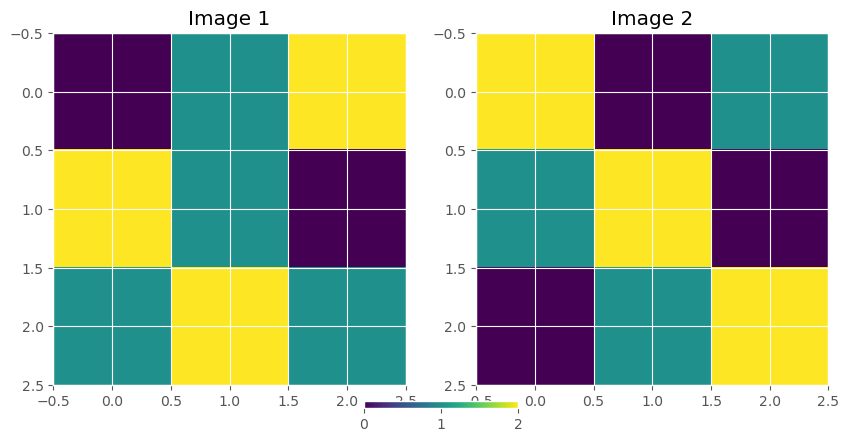

In [24]:
import numpy as np
import matplotlib.colors as mcolors

# Create sample data
image1 = np.array([[0, 1, 2], [2, 1, 0], [1, 2, 1]])
image2 = np.array([[2, 0, 1], [1, 2, 0], [0, 1, 2]])

# Define the colormap and normalization
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=2)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im1 = axes[0].imshow(image1, cmap=cmap, norm=norm)
axes[0].set_title('Image 1')

im2 = axes[1].imshow(image2, cmap=cmap, norm=norm)
axes[1].set_title('Image 2')

# Add colorbar
fig.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)

plt.show()

In [25]:
image1

array([[0, 1, 2],
       [2, 1, 0],
       [1, 2, 1]])

In [26]:
image2

array([[2, 0, 1],
       [1, 2, 0],
       [0, 1, 2]])

In [27]:
#1 is blue
# 2 is green
# 3 is red
# 0 is black

In [28]:
wavy = [0, 2, 3, 4]
wavy[1:3]

[2, 3]